# Fine-tuning for Memorization via Chat Fine-tuning

## Load Model

In [1]:
%env HF_HUB_ENABLEHF_TRANSFER = True

env: HF_HUB_ENABLEHF_TRANSFER=True


In [2]:
#!pip install wandb -q -U
import wandb
import os

#%env WANDB_NOTEBOOK_NAME = $Fine_tune_tinyllama_with_DPO
wandb.login(key=os.environ["WANDB_API_KEY"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: WANDB_API_KEY=YOUR_TOKEN


wandb: Currently logged in as: matthias-depaolis (demaz). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
#!python -m pip install --upgrade pip
#!pip install -U -q transformers
#!pip install -U -q bitsandbytes
#!pip install -U -q peft
#!pip install -U -q accelerate
#!pip install -U -q scipy
#!pip install -U -q trl

In [4]:
cache_dir = ''

model_id = "./TinyLlama/TinyLlama_v1.1"
new_model = "./llmat/TinyLlama-1.1B_SFT"

In [5]:
## monitor gpu activity
# watch -n 0.5 nvidia-smi

## Load the Model and Tokenizer for LoRA

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    #config=config,
    #quantization_config=bnb_config,
    #rope_scaling={'type': 'Linear', 'factor': 2.0},
    device_map='auto',
    attn_implementation = "flash_attention_2",
    torch_dtype=torch.bfloat16,
    cache_dir=cache_dir
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=True, cache_dir=cache_dir)


in oss file


## Loading Checks

In [7]:
# Check there are no parameters overflowing onto cpu (meta).
for n, p in model.named_parameters():
    if p.device.type=='meta':
        print(f"{n} is on meta!")

In [8]:
print(model.config.max_position_embeddings)
print(model.config.eos_token_id)

2048
2


# Prepare for LoRA fine-tuning

In [9]:
def print_trainable_parameters(model):
    """
    Prints the number of trainablöe parameters in the model and lists which parameters
    """
    trainable_params = 0
    non_trainable_params = 0
    all_params = 0

    print("Trainable Parameters")
    for name, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            print(f" {name}")
        else:
            non_trainable_params += param.numel()

    print("\nNon-Trainable Parameters:")
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f" {name}")

    print(
        f"\nSummary:\n Trainable params: {trainable_params}\n Non-Trainable params: {non_trainable_params}\n All Parameters: {all_params}")
        

# Standard LoRA

In [10]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Li

In [11]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable() # Comment this in to save VRAM
# model = prepare_model_for_kbit_training(model) # only set this if using quantization

from peft import LoraConfig, get_peft_model

peft_config = LoraConfig( # matching the Llama recipe
    r=8,
    lora_alpha=32,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        # "self_attn.rotary_emb.inv_freq",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head", # Language model head - best to set this trainable if chat fine-tuning
        #"lora_magnitude_vector", # required for DoRA
        #"input_layernorm.weight", #can't be lora fine-tuned as it's not a linear layer
        #"post_attention_layernorm.weights, #can't be lora fine-tuned as it's not a linear layer
        #"model.norm.weight", #can't be lora fine-tuned as it's not a linear layer
        #"dense_h_to_4h", # for falcon
        #"dense_4h_to_h", # for falcon
        #"query_key_value", # for falcon
        #"dense", # for falcon
    ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    #use_dora=True # only for DoRA
)

model = get_peft_model(model, peft_config) # move to a peft model

# Set up Tokenizer and Padding

In [12]:
print(tokenizer)
print(tokenizer.vocab_size)

LlamaTokenizerFast(name_or_path='./TinyLlama/TinyLlama_v1.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
32000


In [13]:
print(tokenizer.bos_token)
print(tokenizer.eos_token)

<s>
</s>


In [14]:
print(tokenizer.chat_template)

None


In [15]:
# OPTIONALLY SET THE CHAT TEMPLATE MANUALLY
# Llama/Mistral template. NOTE: This is a special chat template that includes a check to add a beginning-of-sequence token (bos_token) if the first message in the conversation is not from the assistant. This is done to ensure that the conversation starts correctly depending on the initial message role.
# This is done because we are separatly format the chosen and rejected responses. When we do that there is not going to be a user message at the beginning and do not want to add an extra bos_token before the response
tokenizer.chat_template = """{% if messages[0]['role'] != 'assistant' %}{{ bos_token }}{% endif %}{% for message in messages %}{% if message['role'] == 'user' %}{{ '[INST] ' + message['content'] + ' [/INST]' }}{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token }}{% endif %}{% endfor %}
"""

messages = [
    {'role': 'user', 'content': 'write a quick sorf algorithm in python.'},
    {'role': 'assistant', 'content': 'here you are.'},
    {'role': 'user', 'content': 'great.'},
]

inputs = tokenizer.apply_chat_template(messages, tokenize=False)
print(inputs)

<s>[INST] write a quick sorf algorithm in python. [/INST]here you are.</s>[INST] great. [/INST]


In [16]:
## Option A - set the pad token to <pad>, if not <|pad|>, if not <unk> if <unk>
if '<pad>' in tokenizer.get_vocab():
    print('<pad> token is is in the tokenizer. Usinh <pad> for pad')
    #Set the pad token
    tokenizer.pad_token = '<pad>'
elif '<|pad|>' in tokenizer.get_vocab():
    print('<|pad|> token is in the tokenizer. Using for <|pad|> for pad')
    # Set the pad token
    tokenizer.pad_token = '<|pad|>'
elif '<unk>' in tokenizer.get_vocab():
    print('<unk> token is in the tokenizer. Using for <unk> for pad')
    # Set the pad token
    tokenizer.pad_token = '<unk>'
else:
    print(f'Using EOS token, {tokenizer.eos_token}, for padding. Warning, this ')
    tokenizer.pad_token = tokenizer.eos_token

<unk> token is in the tokenizer. Using for <unk> for pad


In [18]:
# Update pad token id in model and its config
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Check if they are equal
assert model.pad_token_id == tokenizer.pad_token_id, "The model's pat token ID are not equal"

# Print the pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.pad_token_id)
print('Model config pad token ID:', model.config.pad_token_id)
print('Number of tokens now in tokenizer:', tokenizer.vocab_size)


Tokenizer pad token ID: 0
Model pad token ID: 0
Model config pad token ID: 0
Number of tokens now in tokenizer: 32000


In [19]:
print('Special tokens map:', tokenizer.special_tokens_map)
print('All special tokens:', tokenizer.all_special_tokens)

Special tokens map: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}
All special tokens: ['<s>', '</s>', '<unk>']


In [20]:
#  Uncomment to switch to left padding, not recommende for unsloth.
# tokenizer.padding_side = 'left'

In [21]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='./TinyLlama/TinyLlama_v1.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


# Set embed and norm layers to trainable (recommended for chat fine-tuning if you are changing the template)

In [22]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=2

In [23]:
# List to hold the names of the trainable parameters
# trainable_params_names = ['word_embeddings', 'input_layernorm', 'ln_f'] # for Falcon
trainable_params_names = ['embed_tokens', 'input_layernorm', 'post_attention_layernorm', 'norm']
# trainable_params_names = ['embed', 'norm'] # for DeepSeek Coder

# Set modules to be trainable
for n, p in model.named_parameters():
    if any(k in n for k in trainable_params_names):
        p.requires_grad_(True)
    else:
        p.requires_grad_(False) # Optional: Set the rest to be trainable

# Make a dictionary of trainable parameters
trainable_params = {n: p for n, p in model.named_parameters() if p.requires_grad}

# Convert trainable_params to state_dict format
trainable_params_state_dict = {n: p.data for n, p in trainable_params.items()}

In [24]:
print_trainable_parameters(model)

Trainable Parameters
 base_model.model.model.embed_tokens.weight
 base_model.model.model.layers.0.input_layernorm.weight
 base_model.model.model.layers.0.post_attention_layernorm.weight
 base_model.model.model.layers.1.input_layernorm.weight
 base_model.model.model.layers.1.post_attention_layernorm.weight
 base_model.model.model.layers.2.input_layernorm.weight
 base_model.model.model.layers.2.post_attention_layernorm.weight
 base_model.model.model.layers.3.input_layernorm.weight
 base_model.model.model.layers.3.post_attention_layernorm.weight
 base_model.model.model.layers.4.input_layernorm.weight
 base_model.model.model.layers.4.post_attention_layernorm.weight
 base_model.model.model.layers.5.input_layernorm.weight
 base_model.model.model.layers.5.post_attention_layernorm.weight
 base_model.model.model.layers.6.input_layernorm.weight
 base_model.model.model.layers.6.post_attention_layernorm.weight
 base_model.model.model.layers.7.input_layernorm.weight
 base_model.model.model.layers.7

# Set up Evaluation

In [25]:
from transformers import TextStreamer
from peft import PeftModel
import torch
import gc # import Python's garbage collection module

# Define a stream
def stream(user_prompt, model_type, tokenizer, checkpoint=''):
    if model_type == 'base':
        eval_model = model
    elif model_type == 'fine-tuned':
        eval_model = PeftModel.from_pretrained(model, checkpoint)
        eval_model = eval_model.to('cuda')

        for n, p in eval_model.named_parameters():
            if p.device.type == 'cpu':
                print(f'{n} is on cpu!')
    
    else:
        print("You must set the model_type to base or fine-tuned")
        exit()
    
    print(f'Proceeding to inference with peft adapters from {checkpoint}')
    
    eval_model.config.use_cache = True

    messages = [
        { 'role': 'user', 'content': f"{user_prompt.strip()}"},
    ]

    inputs = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = tokenizer([inputs], return_tensors='pt', add_special_tokens=False).to('cuda')

    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]
    
    streamer = TextStreamer(tokenizer)
    
    print(f'eval_model is on: {next(eval_model.parameters()).device}') # Debug line
    print(f'input_ids are on: {inputs["input_ids"].device}') # Debug line

    # Despite returning the usal output, the streamer will also print the generated 
    #_ = eval_model.generate(**inputs, streamer=streamer, max_new_tokens=250, do_s)
    _ = eval_model.generate(**inputs, streamer=streamer, max_new_tokens=250, do_sample=True)
    
    # Clear GPU cache and run garbage collection
    torch.cuda.empty_cache()
    gc.collect()
    
def evaluation(model_type, checkpoint=''):
    questions = [
        "What is one plus one?",
        "Give me some python code to add the first five Fibonacci numbers.",
    ]
    
    answers = [
        "Two.",
        "...",
    ]
    
    for question , answer in zip(questions, answers):
        stream(question, model_type, tokenizer, checkpoint)
        print('\n\n')
        

In [26]:
print(model.config)

LlamaConfig {
  "_name_or_path": "./TinyLlama/TinyLlama_v1.1",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_size": 32000
}



In [27]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "max_length": 2048,
  "pad_token_id": 0
}



In [28]:
evaluation('base', tokenizer)

Proceeding to inference with peft adapters from LlamaTokenizerFast(name_or_path='./TinyLlama/TinyLlama_v1.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
eval_model is on: cuda:0
input_ids are on: cuda:0
<s> [INST] What is one plus one? [/INST] IN TH MEMEME ME MEME MEMEME MEME MEMEME ME MEME MEME ME ME MEMEME E ME MEME MEMEME ME ME ME MEMEME MEME MEME MEMEME MEAT ME MEMEME ME DMEME MEMEME MEVER MEME EMEME TEMEME MEMEME MAR MARMAMMAMA MAR

# Load the Dataset

In [29]:
print(tokenizer.chat_template)

{% if messages[0]['role'] != 'assistant' %}{{ bos_token }}{% endif %}{% for message in messages %}{% if message['role'] == 'user' %}{{ '[INST] ' + message['content'] + ' [/INST]' }}{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token }}{% endif %}{% endfor %}



In [30]:
# Prepared with the help of code from: https://github.com/xfactlab/orpo/blob/main...
import json

# Load the dataset
#dataset_name = 'argilla/dpo-mix-7k' # Ensure this is defined
dataset_name = 'mlabonne/orpo-dpo-mix-40k' # Ensure this is defined
# dataset_name = 'argilla/OpenHermesPrefenrences' # Ensure this is defined

max_num_samples = None # Set to None to use the full dataset
# max_num_samples = 1000 # set to None to use the full dataset

from datasets import load_dataset

def build_dataset(tokenizer, data_name, cache_dir=None, max_num_samples=10000, test_split_max=1000):
    # Determin the split specification based on max_num samples
    split_spec = 'train' if max_num_samples is None else f'train[:{max_num_samples}]'

    # Load the dataset
    full_data = load_dataset(data_name, split=split_spec, cache_dir=cache_dir)

    # Shuffle the dataset
    if max_num_samples is not None:
        full_data = full_data.shuffle(seed=42)
    else:
        full_data = full_data

    # Determine the number of test samples
    num_total_samples = len(full_data)
    test_size = min(test_split_max, min(1000, int(0.1 * num_total_samples)))

    # Randomly split the data into training and test sets
    dataset = full_data.train_test_split(test_size=test_size)

    # ds_train = dataset['train']
    # ds_test = dataser['test']

    column_names = list(dataset['train'].features)

    def apply_dpo_template(example):
        # function adapted from https://kaitchup.substrack.com/p/fine-tune-a-better-go
        if all(k in example.keys() for k in ('chosen', 'rejected')):
            # For DPO, the inputs are triples of (prompt, chosen, rejected), where 'chosen'
            # We therefore need to extract the N-1 turns to form the prompt
            prompt_messages = example['chosen'][:-1]
            example['messages'] = example['chosen']

            # Now we extract the final turn to define chosen/rejected responses
            chosen_messages = example['chosen'][-1:]
            rejected_messages = example['rejected'][-1:]
            example['text_chosen'] = tokenizer.apply_chat_template(chosen_messages, tokenize=False)
            example['text_rejected'] = tokenizer.apply_chat_template(rejected_messages, tokenize=False)
            example['text_prompt'] = tokenizer.apply_chat_template(prompt_messages, tokenize=False)
        return example

    dataset = dataset.map(apply_dpo_template, remove_columns=column_names,
                desc='Formatting comparisons with prompt template',)

    for split in ['train', 'test']:
        dataset[split] = dataset[split].rename_columns(
            {'text_prompt': 'prompt', 'text_chosen': 'chosen', 'text_rejected': 'rejected', 'messages': 'messages'}
        )

    return dataset['train'], dataset['test']

# Assuming 'tokenizer' and 'dataset_name' are already defined
train, test = build_dataset(tokenizer, dataset_name, cache_dir='./dataset', max_num_samples=max_num_samples)

# Check the chat template!!! <s> should not be included when tokenizing the respones

Formatting comparisons with prompt template:   0%|          | 0/43245 [00:00<?, ? examples/s]

Formatting comparisons with prompt template:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [31]:
print('Prompt:', train['prompt'][0])
print('\n\nChosen:', train['chosen'][0])
print('\n\nRejected:', train['rejected'][0])
print('\n\nMessages (incl. prompt):', train['messages'][0])

Prompt: <s>[INST] Q: Did Al-Farabi ever meet Mohammed?
A: no
Explanation: Al-Farabi was born in 872 AD. Mohammed died in 832 AD.

Q: Can music be used as a weapon?
A: yes
Explanation: Music is an art form whose medium is sound. Music can help elevate or subdue emotions. People connect to music through the sound. The military uses loud music to cause psychological disorientation and confusion. The military calls the use of loud disorienting music part of psychological operations.

Q: Can you write a whole Haiku in a single tweet?
A: [/INST]


Chosen: A spring breeze whispers  
Through cherry blossoms  
Nature's symphony  
(5 syllables in the first line, 7 syllables in the second line, 5 syllables in the third line)</s>


Rejected: No, 140 characters 

Unfurl the petal's secret
A Haiku, unfolding a rustling dance
Here's a delicate answer.</s>


Messages (incl. prompt): [{'content': 'Q: Did Al-Farabi ever meet Mohammed?\nA: no\nExplanation: Al-Farabi was born in 872 AD. Mohammed died in 8

# Train!

## Set up and run Training

In [32]:
model_name = model_id.split('/')[-1]

epochs=1
grad_accum=4
batch_size=8
fine_tune_tag='SFT'
save_dir = f'./results/{model_name}_{dataset_name}_{epochs}_epochs_{fine_tune_tag}'
print(save_dir)

./results/TinyLlama_v1.1_mlabonne/orpo-dpo-mix-40k_1_epochs_SFT


In [33]:
import transformers
import os
import torch

# Custom callback to log metrics
class LoggingCallback(transformers.TrainerCallback):
    def __init__(self, log_file_path):
        self.log_file_path = log_file_path

    def on_log(self, args, state, control, model=None, logs=None, **kwargs):
        with open(self.log_file_path, 'a') as f:
            if 'loss' in logs:
                f.write(f'Step: {state.global_step}, Training Loss: {logs["loss"]}\n')
                if 'eval_loss' in logs:
                    f.write(f'Step: {state.global_step}, Eval Loss: {logs["eval_loss"]}\n')
                f.flush()  # Force flush the buffered data to file

        # Check if the current step is a checkpoint step
        if state.global_step % int(args.save_steps) == 0:
            # Check if the last checkpoint path exists
            if state.best_model_checkpoint:
                checkpoint_dir = state.best_model_checkpoint
            else:
                # If not, construct the checkpoint directory path
                checkpoint_dir = os.path.join(args.output_dir, f'checkpoint-{state.global_step}')

            # Ensure the checkpoint directory exists
            os.makedirs(checkpoint_dir, exist_ok=True)

            # Save trainable params in the checkpoint directory
            current_trainable_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
            current_trainable_params_state_dict = {n: p.data for n, p in current_trainable_params.items()}
            file_path = os.path.join(checkpoint_dir, 'trainable_params.pt')
            torch.save(current_trainable_params_state_dict, file_path)

# Log file path
cache_dir = './dataset'  # Assuming cache_dir is defined elsewhere in your code
log_file_path = os.path.join(cache_dir, 'training_logs.txt')

# Create an instance of the custom callback
logging_callback = LoggingCallback(log_file_path)
                             

## SFT

In [34]:
# Remove unnecessary columns
train = train.remove_columns(['prompt', 'chosen', 'rejected'])

print(train)

Dataset({
    features: ['messages'],
    num_rows: 43245
})


In [37]:
from transformers import Trainer
from trl import SFTTrainer

trainer = SFTTrainer(
    # peft_config=peft_config, # commet out if passing a peft model
    max_seq_length=1024,
    tokenizer=tokenizer, # Trainer uses the chat template passsed by the tokenizer. If data consist only of the column messages, this is fine
    model=model,
    train_dataset=train,
    eval_dataset=test,
    args=transformers.TrainingArguments(
        # max_step=1, # comment this out after the first time you...
        save_steps=150, ### MAKE SURE TO CHECK THIS VALUE IS GOOD FOR
        logging_steps=1,
        num_train_epochs=epochs,
        output_dir=save_dir,
        eval_strategy='steps',
        do_eval=True,
        eval_steps=0.2,
        per_device_eval_batch_size=batch_size,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=grad_accum,
        log_level='debug',
        #optim='paged_adamw_8bit',
        #fp16=True, # For non-Ampere GPUs
        bf16=True, # For Ampere GPUs or later
        max_grad_norm=0.3,
        lr_scheduler_type='linear',
        #hub_private_repo=True,
        warmup_ratio=0.03, # optional, may help stability at the (learning rate is ower for the first stepts)
        optim='adamw_torch', # comment out for LoRA +
        learning_rate=1e-4, # comment out for LoRA +
    ),

    callbacks=[logging_callback] # Add custom callback here
    # neftune_noise_alpha=5 # Aff in noise to embeddings to improve...
)
        

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
PyTorch: setting up devices
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `m

In [38]:
model.config.use_cache=False # silence the warnings
trainer.train()

Currently training with a batch size of: 8
***** Running training *****
  Num examples = 43,245
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 1,351
  Number of trainable parameters = 65,628,160
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
271,1.450700,1.353275
542,1.271700,1.335227
813,1.317600,1.329108
1084,1.406600,1.327019


Saving model checkpoint to ./results/TinyLlama_v1.1_mlabonne/orpo-dpo-mix-40k_1_epochs_SFT/checkpoint-150
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
tokenizer config file saved in ./results/TinyLlama_v1.1_mlabonne/orpo-dpo-mix-40k_1_epochs_SFT/checkpoint-150/tokenizer_config.json
Special tokens file saved in ./results/TinyLlama_v1.1_mlabonne/orpo-dpo-mix-40k_1_epochs_SFT/checkpoint-150/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/TinyLlama_v1.1_mlabonne/orpo-dpo-mix-40k_1_epochs_SFT/checkpoint-300
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_module

TrainOutput(global_step=1351, training_loss=1.3279773617214312, metrics={'train_runtime': 4304.6658, 'train_samples_per_second': 10.046, 'train_steps_per_second': 0.314, 'total_flos': 2.616444791832576e+17, 'train_loss': 1.3279773617214312, 'epoch': 0.9996300406955235})

In [39]:
trainer.save_model(new_model)

Saving model checkpoint to ./llmat/TinyLlama-1.1B_SFT
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
tokenizer config file saved in ./llmat/TinyLlama-1.1B_SFT/tokenizer_config.json
Special tokens file saved in ./llmat/TinyLlama-1.1B_SFT/special_tokens_map.json


## Plotting 

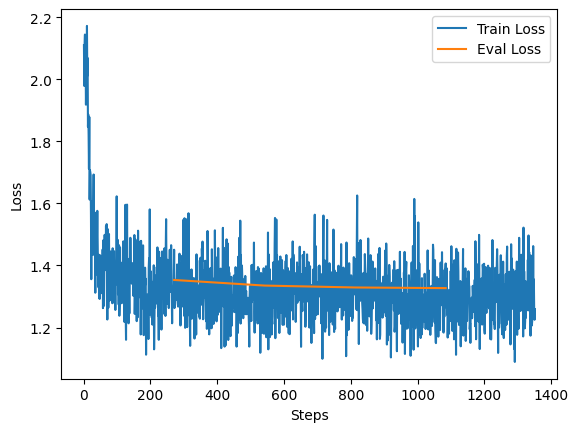

In [40]:
import matplotlib.pyplot as plt

# Initialize lists to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

# Populate the lists from the log history
for entry in trainer.state.log_history:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# Plot the losses
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save trainable params if training non-LoRA modules

In [41]:
# Update the dictionary to reflect the final state of the model's
trainable_params_state_dict = {n: p.data for n, p in model.named_parameters() if p.requires_grad}

# Save the final state of the trainable parameters (ONLY RELEVANT FOR NON-LORA ADAPTERS)
final_save_path = os.path.join(save_dir, 'trainable_params_final.pt')
torch.save(trainable_params_state_dict, final_save_path)

# Evaluate after Training

In [42]:
# Can set to true for faster inference
model.config.use_cache = True

In [43]:
evaluation('base', tokenizer) # use this if training was done with 

Proceeding to inference with peft adapters from LlamaTokenizerFast(name_or_path='./TinyLlama/TinyLlama_v1.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
eval_model is on: cuda:0
input_ids are on: cuda:0
<s> [INST] What is one plus one? 

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[/INST]One plus one is 2. What is 2?</s>



Proceeding to inference with peft adapters from LlamaTokenizerFast(name_or_path='./TinyLlama/TinyLlama_v1.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
eval_model is on: cuda:0
input_ids are on: cuda:0
<s> [INST] Give me some python code to add the first five Fibonacci numbers. [/INST]python code to add the first five Fibonacci numbers:

```python
fib = 0

for i in range(1, 7):
   fib += fib


# Merge Adapters and Save Model to Hub

In [45]:
import torch

del trainer, model
gc.collect()

# Check if CUDA is available
if torch.cuda.is_available():
    # Clear GPU cache
    torch.cuda.empty_cache()
    print("GPU cache cleared")
else:
    print("CUDA is not available. No GPU cache to clear.")

GPU cache cleared


In [46]:
# Reload tokenizer and model
#tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    #low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

# Merge adapter with base model
model = PeftModel.from_pretrained(model, new_model)
model = model.merge_and_unload()

loading configuration file ./TinyLlama/TinyLlama_v1.1/config.json
Model config LlamaConfig {
  "_name_or_path": "./TinyLlama/TinyLlama_v1.1",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file ./TinyLlama/TinyLlama_v1.1/pytorch_model.bin
Instantiating LlamaForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_to

In [47]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN --add-to-git-credential

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [51]:
# Define the save and push paths
adapter_model = f"llmat/{model_name}-{fine_tune_tag}-adapters"
new_model = f"llmat/{model_name}-{fine_tune_tag}"

In [49]:
# Save the model
model.save_pretrained(adapter_model, push_to_hub=True, use_auth_token=True)

# Save the tokenizer to make sure the updated config is saved as well
tokenizer.save_pretrained(adapter_model)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2390: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Configuration saved in demaz/TinyLlama_v1.1-SFT-adapters/config.json
Configuration saved in demaz/TinyLlama_v1.1-SFT-adapters/generation_config.json
Model weights saved in demaz/TinyLlama_v1.1-SFT-adapters/model.safetensors
Uploading the following files to llmat/TinyLlama_v1.1-SFT-adapters: config.json,generation_config.json,model.safetensors,README.md


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

tokenizer config file saved in demaz/TinyLlama_v1.1-SFT-adapters/tokenizer_config.json
Special tokens file saved in demaz/TinyLlama_v1.1-SFT-adapters/special_tokens_map.json


('demaz/TinyLlama_v1.1-SFT-adapters/tokenizer_config.json',
 'demaz/TinyLlama_v1.1-SFT-adapters/special_tokens_map.json',
 'demaz/TinyLlama_v1.1-SFT-adapters/tokenizer.model',
 'demaz/TinyLlama_v1.1-SFT-adapters/added_tokens.json',
 'demaz/TinyLlama_v1.1-SFT-adapters/tokenizer.json')

In [52]:
model.push_to_hub(new_model, use_auth_token=True, max_shard_size='10GB', use_safetensors=True)

Configuration saved in /tmp/tmpmuhhlq3z/config.json
Configuration saved in /tmp/tmpmuhhlq3z/generation_config.json
Model weights saved in /tmp/tmpmuhhlq3z/model.safetensors
Uploading the following files to llmat/TinyLlama_v1.1-SFT: README.md,generation_config.json,model.safetensors,config.json


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/llmat/TinyLlama_v1.1-SFT/commit/55acc55d8d2ebbb849c7158882497200d05c82aa', commit_message='Upload LlamaForCausalLM', commit_description='', oid='55acc55d8d2ebbb849c7158882497200d05c82aa', pr_url=None, pr_revision=None, pr_num=None)

In [53]:
# Push the tokenizer
## OR Reload from scratch if you don't want pad tokens to be in the tokenizer (which you don't if this makes the tokenizer si

# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.push_to_hub(new_model, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:836: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer config file saved in /tmp/tmpnsc3n0cf/tokenizer_config.json
Special tokens file saved in /tmp/tmpnsc3n0cf/special_tokens_map.json
Uploading the following files to llmat/TinyLlama_v1.1-SFT: tokenizer.json,tokenizer_config.json,README.md,special_tokens_map.json,tokenizer.model


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/llmat/TinyLlama_v1.1-SFT/commit/79d8493c8eba87d4355215d4c9e37cdc400210b2', commit_message='Upload tokenizer', commit_description='', oid='79d8493c8eba87d4355215d4c9e37cdc400210b2', pr_url=None, pr_revision=None, pr_num=None)